# DANCE-ML 2020 intro to machine learning tutorial
### AUTHORS: 
### Scott Kravitz (swkravitz@lbl.gov)
#### Adapted from a tutorial by Scott Kravitz, Micah Buuck (mbuuck@slac.stanford.edu), and Reed Watson (watson_james@berkeley.edu)
### DATE: August 2020
##### **Run on Google colab [here](https://colab.research.google.com/github/swkravitz/dance-ml-2020-tutorial/blob/master/DANCE_ML_Intro_Tutorial.ipynb) **
This example runs through all of the major conceptual steps involved in a common machine learning application. It is focused on fairly basic algorithms (boosted decision trees and multi-layer perceptrons i.e. simple neural nets) that use only a few high-level input variables and do not require much tuning by the user. 
It is meant to show how to load and investigate particle physics data in ROOT format with uproot, train a basic model, gauge its performance, and save the model for future use. 

Specifically, we consider the toy case of distinguishing data from two standard calibration sources in LUX, a liquid xenon TPC dark matter detector. These two sources are CH3T (tritium) events, which are electron recoils (background-like), and DD events, which are nuclear recoils (similar to a WIMP dark matter signal).


**Quick intro to LUX here**

<img src="https://raw.githubusercontent.com/swkravitz/dance-ml-2020-tutorial/master/images/LUX_TPC.png" width="600">

**How data was generated using NEST here**

**Aside on packages:** We focus on the scikit-learn package for boosted decision trees and the TensorFlow 2 package for neural nets. TensorFlow 2 is an excellent package for most modern deep learning, i.e. neural nets of all kinds. scikit-learn has the benefit of having the widest variety of machine learning algorithms and being well-documented; it also includes a number of helper functions that are useful for data prep and performance evaluation, regardless of which package is used for training. There is also an XGBoost section at the end that goes through the corresponding code for training and investigating a boosted decision tree - it is a dedicated package for boosted decision trees, and is generally more performant and has more features than sklearn's BDT.

**To run on Google colab, you must install the uproot package:**

In [ ]:
!pip install --user -q uproot

`!` is an IPython magic command which causes the subsequent line to be executed by the shell instead of with the Python interpreter. Documentation on it can be found at https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-system

**<p style="color:red;">Note: After installing packages (such as uproot), you will have to restart the kernel for the changes to take effect (from top menu, Runtime -> Restart runtime). If running on your own machine, install the additional packages below; you may find errors related to outdated versions of those packages, which can be solved by running the corresponding pip command with the --U flag added to the other flags (you may want to remove -q so you can see the status output).</p>**

In [1]:
# If you want to run this locally, here are some important packages to ensure you have installed:

#Install necessary packages if they are not already installed. Remove
# the -q if you want to see status output.
# !pip install --user -q uproot
# !pip install --user -q pandas
# !pip install --user -q numpy
# !pip install --user -q matplotlib
# !pip install --user -q seaborn

# If you don't have TensorFlow already, run this:
# !pip install --user -q tensorflow
# You may also need to install other packages, like ipykernel, or may have to upgrade dependencies (add the -U flag to pip commands to upgrade)
# We do not attempt to include all dependencies for running on your local environment here

In [1]:
# Generic imports for almost all Python work
import numpy as np
import matplotlib.pyplot as plt

## Load our dataset

We want to get the variables in the "nest" tree of the ROOT files of interest, and you can do that easily with the `uproot` package as shown below. 

In practice, you will probably want to do the initial steps of compiling events and applying cuts to get a good training dataset as a separate step, as this can be time intensive for larger datasets. 

In [2]:
import uproot
import pandas as pd

# Prepare to read in ROOT data
tree="nest"

# The list of features we'll read in; not all will be used in the analysis.
# If you want to consider other variables, add them here.
branch_names = ['s1Area_phd','s2Area_phd','driftTime_us','x_cm','y_cm', 'z_cm', 'E_recon_keV']

# The number of events of each class (CH3T vs DD) we want to use for training; often you will use all the data you have access to, here we restrict the numbers for testing speed
n_evts_target = 10000

# We'll apply some basic cuts later; make sure CH3T and DD cuts are the same
drift_max = 300 # us; cut away from the cathode at bottom, not carefully-chosen
s1_max = 150 # phd; ignore events of particularly high energy

We are going to train an algorithm to identify a scatter as originating from either "ER" (single-scatters from CH3T data) or "NR" (single-scatters from DD data). We are going to train a [boosted decision tree](https://en.wikipedia.org/wiki/Gradient_boosting) with scikit-learn, a simple [3-layer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) in TensorFlow, and a BDT using [XGBoost](https://xgboost.readthedocs.io/en/latest/)).

We'll use [uproot](https://pypi.org/project/uproot/) to read in the data. Uproot is a Python package for importing ROOT-formatted data into Python that does not itself depend on ROOT. It also has easy-to-use interfaces to [Pandas](https://pandas.pydata.org/), which is a useful data-manipulation and -analysis tool that interfaces nicely with TensorFlow. These tools facilitate reading an LZap output file into Python in just a handful of lines of code.

**When running on Google colab, the data must be downloaded first:**

In [4]:
! mkdir -p 'data'
! wget -nv -O data/CH3TData.root https://github.com/swkravitz/dance-ml-2020-tutorial/blob/master/data/CH3TData.root?raw=true
! wget -nv -O data/DDData.root https://github.com/swkravitz/dance-ml-2020-tutorial/blob/master/data/DDData.root?raw=true

2020-07-31 18:14:20 URL:https://raw.githubusercontent.com/swkravitz/dance-ml-2020-tutorial/master/data/CH3TData.root [1824247/1824247] -> "data/CH3TData.root" [1]
2020-07-31 18:14:21 URL:https://raw.githubusercontent.com/swkravitz/dance-ml-2020-tutorial/master/data/DDData.root [1398037/1398037] -> "data/DDData.root" [1]


In [3]:
# Get DD data
dd_fname = 'DDData.root'
dd_nest = uproot.open( 'data/'+dd_fname )["nest"]
dd_df = dd_nest.pandas.df(branch_names)

# Basic quality cuts
dd_df = dd_df[dd_df['driftTime_us']<drift_max]
dd_df = dd_df[dd_df['s1Area_phd']<s1_max] 

# Label DD events as class 1 (signal) - this is what tells the algorithm what the correct answer is
dd_df['class'] = 1

print("Total DD SS events after cuts: ",len(dd_df))
if len(dd_df)>n_evts_target: dd_df = dd_df.head(n_evts_target)
print("DD events used in training/testing data: ",len(dd_df))

Total DD SS events after cuts:  66898
DD events used in training/testing data:  10000


In [4]:
# Get CH3T data
ch3t_fname = 'CH3TData.root'
ch3t_nest = uproot.open( 'data/'+ch3t_fname )["nest"]
ch3t_df = ch3t_nest.pandas.df(branch_names)

# Basic quality cuts
ch3t_df = ch3t_df[ch3t_df['driftTime_us']<drift_max]
ch3t_df = ch3t_df[ch3t_df['s1Area_phd']<s1_max] 

# Label CH3T events as class 0 (background) - this is what tells the algorithm what the correct answer is
ch3t_df['class'] = 0

print("Total CH3T SS events after cuts: ",len(ch3t_df))
if len(ch3t_df)>n_evts_target: ch3t_df = ch3t_df.head(n_evts_target)
print("CH3T events used in training/testing data: ",len(dd_df))

Total CH3T SS events after cuts:  87160
CH3T events used in training/testing data:  10000


In [5]:
# Combine signal and background datasets
df = ch3t_df.append(dd_df)
df = df.sample(frac=1).reset_index(drop=True) # Sort 

# We can rename variables if desired
#df = df.rename(columns={'ss.x_cm':'x'})

# Get some simple derived variables (more human-interpretable; not necessary for deep learning applications, may help simpler algorithms)
df['log10s2Area_phd'] = np.log10(df['s2Area_phd'])
df['r_cm'] = np.sqrt(df['x_cm']**2+df['y_cm']**2)

# Separate class info from inputs (no cheating!)
y_df = df.pop('class')

## Visualize the data

It's important to understand the structure of your data and its information content before you launch into trying to analyze it with any ML technique. You can do this with ROOT if that is more comfortable for you, but since this is a Python-based tutorial we will use Python tools.

#### The legend is on the right-hand side of the plots (green = DD, orange = CH3T)

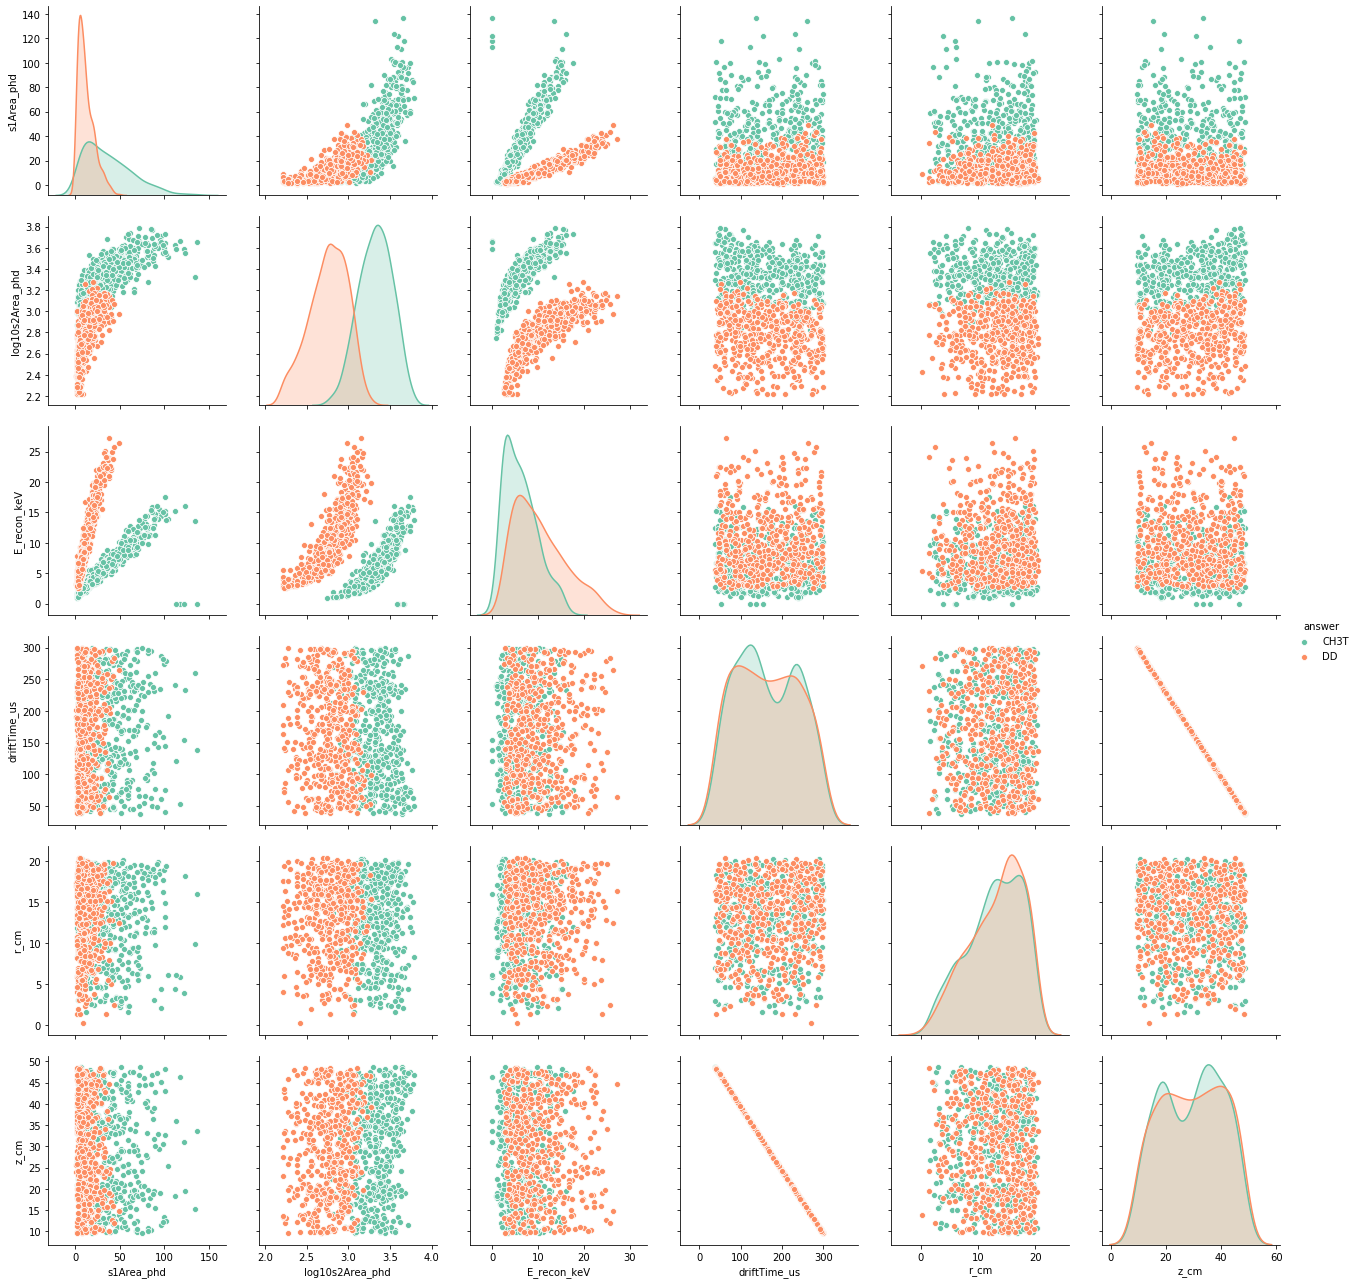

In [9]:
import seaborn as sns
# Seaborn is a nice package for data visualization - it has many pre-defined plotting functions and looks pretty

# Only keep some variables for training
variable_names = ['s1Area_phd','log10s2Area_phd','E_recon_keV','driftTime_us','r_cm','z_cm']

# Make a new column where the answer is a category with the appropriate name, for plotting
df['answer']='CH3T'
df.loc[y_df==1,'answer']='DD'
df['answer'] = df['answer'].astype('category')

# Plot input distributions and visualize correlations; only look at a subset of events for scatter plotting
g = sns.pairplot(df.head(1000), vars=variable_names, hue='answer', palette="Set2", height=3) # Diagonal plots are smoothed using kernel density estimator; skip with diag_kind='hist'

Let's also see how correlated the input variables are; if one variable is highly-correlated with another, it may be a good candidate for removal to simplify the results

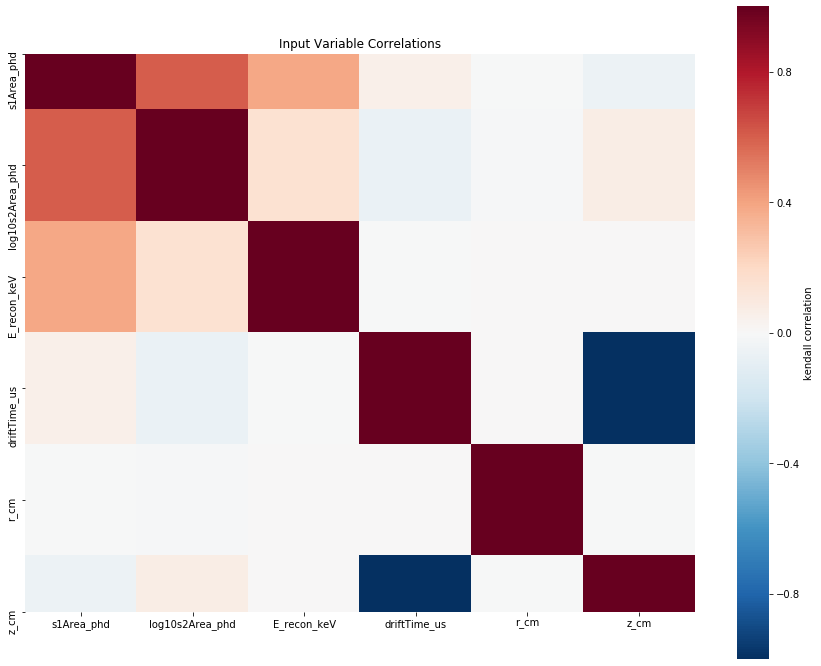

In [10]:
# Show correlation coefficients across variables
# Different correlation coefficients compared here: https://datascience.stackexchange.com/questions/64260/pearson-vs-spearman-vs-kendall
# Generically, Kendall only requires a monotonic relationship (not linear) and is more robust to outliers, as it only uses rank information (quantiles)
# Pearson includes a bit more information but assumes normal distributions and linear relationships
#method = 'pearson'
method = 'kendall'
correlations = df[variable_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (15,12))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

In [11]:
# Drift time and z are perfectly (anti-)correlated; only include one for simplicity
variable_names.remove('driftTime_us')
# Let's also remove the energy variable - e.g. the simulated resolution is unrealistically good
variable_names.remove('E_recon_keV')

## Scale data and split into train/test sets

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reduce to only the variables we want to train on, use numpy array format
X_unscaled = np.array(df[variable_names])
Y = np.array(y_df)

# Split data into training and testing (70/30 split); shuffle order, just in case the indexing of the input data carries information
# Stratify option ensures train and test split preserves percentage of samples in each class; most important when one or more classes have low stats
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, Y, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Perform initial transformations - StandardScaler sets mean of each feature to 0, std to 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled) # Use same scaling transformation on test and train data (do not pick a new mean, std)
X = scaler.transform(X_unscaled) 

## Boosted decision trees

What's a decision tree? 

<img src="https://raw.githubusercontent.com/swkravitz/dance-ml-2020-tutorial/master/images/DT_example.png">

(Source: [A Visual Introduction to Machine Learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/))

**Training of a single decision tree (recursive algorithm):**

At each node, cut (both which variable and cut value) is chosen to maximize some measure of separation between data classes (that have survived previous cuts) - greedy!

Set termination condition (nsamples too small, max depth reached, separation increase too small) 

We can always keep making cuts until each node is all of one class (possibly just one event per node!) - but this won't generalize to new data (overtraining).

**Boosted decision tree (BDT) algorithm:**

Single decision tree is quite limited (“weak classifier”), prone to overtraining

Boosting allows “team effort” to overcome both

After initial training, take misclassified events and weight higher in training dataset 

Train another decision tree on new dataset, etc.

Output of BDT is (performance-weighted) sum of individual trees (sum of voxels in feature space)

Bonus: now output is continuous (-1 is most background-like, +1 signal-like)

**Let's make a BDT**

In [13]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier

# Make the base classifier (single decision tree) - not yet trained, includes termination condition
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=10)
# Now combine a bunch of decision trees; number set by n_estimators. 
# The specific way samples are re-weighted is controlled by the AdaBoost algorithm
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(x_train_unscaled, y_train) # BDT looks at each feature independently, so scaling is typically not necessary

What do the decision function outputs look like for signal vs background?

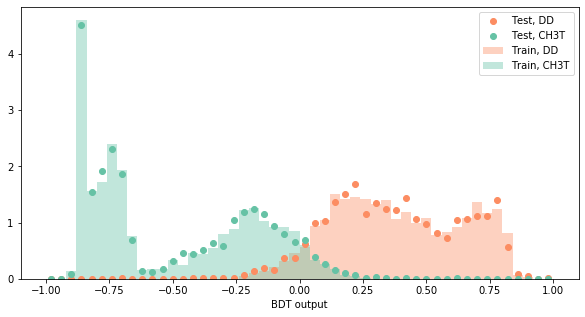

In [14]:
# Evaluate the BDT on the test (and train) data
y_pred_test = model.decision_function(x_test_unscaled)
y_pred_DD_train = model.decision_function(x_train_unscaled[y_train==1])
y_pred_DD_test = model.decision_function(x_test_unscaled[y_test==1])
y_pred_ch3t_train = model.decision_function(x_train_unscaled[y_train==0])
y_pred_ch3t_test = model.decision_function(x_test_unscaled[y_test==0])

n_bins=50
hist_range=(-1.0,1.0)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, DD")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, DD")

plt.hist(y_pred_ch3t_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, CH3T")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, CH3T")

plt.legend()
plt.xlabel('BDT output')
plt.show()

There's pretty good separation between the two cases - that's what we want! The training and testing data distributions look pretty similar by eye, so we're not horribly overtrained. More on this later.

Now let's judge the performance in a more quantitative way, with something call an ROC curve. The name (receiver operating characteristic) is historical, and not very meaningful - let's just focus on what information it contains.

You could imagine placing a cut on the BDT output to remove your backgrounds, but what cut should you choose? As you increase the cut value to higher numbers, you cut out more of the CH3T background, but start losing DD signal events. The ROC curve summarizes this trade-off between background leakage and signal efficiency:

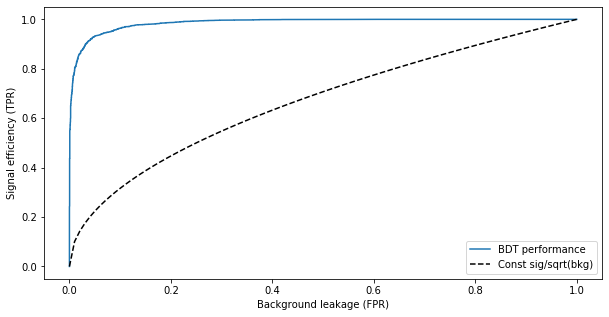

In [15]:
# Use the test data, since the training data can "cheat" by overfitting
BDT_FPR_test, BDT_TPR_test, BDT_TH_test = roc_curve(y_test, y_pred_test, pos_label=1) # Signal class set to 1

plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

n_pts = 100
bkg_eff = np.linspace(0,1,n_pts)
sig_fixed = np.sqrt(bkg_eff)
plt.plot(bkg_eff, sig_fixed, label="Const sig/sqrt(bkg)", color='black', linestyle='--')
plt.legend()
plt.show()

Looks great! Perfect separation would reach the upper left corner of the plot. A simple performance metric for a rare event search (background-dominated) is signal efficiency over square root of background leakage; the dashed line indicates the line of equal performance (according to this metric) to no cut at all, so we're clearly better off applying this cut. 

But we chose an easy test case, so we really care most about the case of very low background leakage. Let's zoom in:

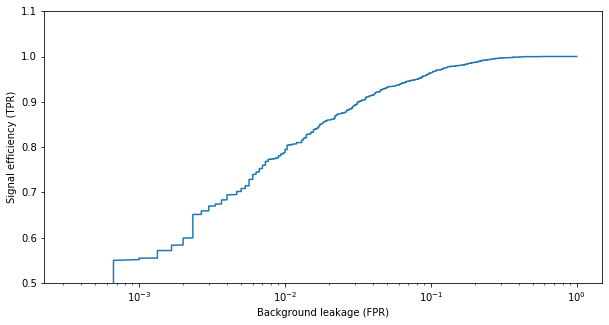

In [16]:
plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT performance")
plt.xscale('log')
plt.ylim((0.5,1.1))
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.show()

Not bad! Are we overtrained?

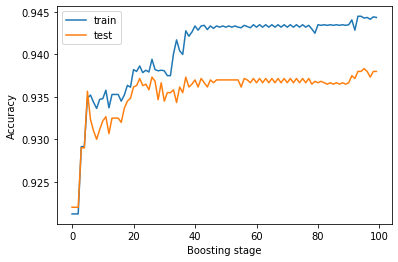

In [17]:
# Get accuracy, ROC AUC vs boosting stage, i.e. number of trees
test_acc, train_acc = [], []
test_auc, train_auc = [], []
for train_predict in model.staged_predict(x_train_unscaled):
    train_acc.append(accuracy_score(y_train, train_predict)) # Can add sample weights here
    
for train_predict in model.staged_decision_function(x_train_unscaled):
    train_auc.append(roc_auc_score(y_train, train_predict))
    
for test_predict in model.staged_predict(x_test_unscaled):
    test_acc.append(accuracy_score(y_test, test_predict)) # Can add sample weights here
    
for test_predict in model.staged_decision_function(x_test_unscaled):
    test_auc.append(roc_auc_score(y_test, test_predict))
    
plt.plot(train_acc,label="train")
plt.plot(test_acc,label="test")
plt.xlabel("Boosting stage")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The pattern above is fairly typical of training: with increased complexity, the model starts being able to fit to the statistical fluctuations of the training data, so the training performance continues to increase and is higher than the test performance. But that doesn't help the performance on the test data. If the test performance is improving but the training performance isn't, we should probably stop training, and may want to try adjusting other parameters to help with this, too.

We also may not want to use accuracy as our metric, since this assumes a particular cut value (0 by default for the BDT), which may not be where we want to cut. One metric that accounts for the full range of possible cut values is the ROC area under the curve (AUC), which is exactly what it sounds like - the integral of the ROC curve. It is similar to accuracy in that it is 0 in the worst case, and 1 in the case of perfect classification. But keep in mind that no single metric can capture the full range of information in the ROC curve.

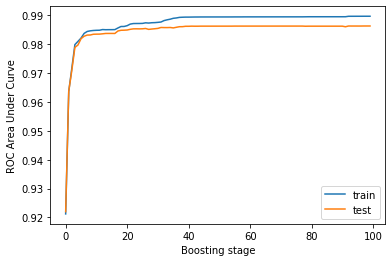

In [18]:
plt.plot(train_auc,label="train")
plt.plot(test_auc,label="test")
plt.xlabel("Boosting stage")
plt.ylabel("ROC Area Under Curve")
plt.legend()
plt.show()

**Now let's try to learn what the algorithm is doing.**

Specifically, boosted decision trees have a means of ranking the importance of different variables in the signal vs background decision. There are different ways of doing this, but they all amount to looking at how frequently a given variable is used to make a split in the tree, with some weighting to account for things like how much the cut improves the performance and how many events reach that node in the first place.

Note that the calculations are done in such a way that the sum of feature rankings is always 1, so it's a relative comparison.

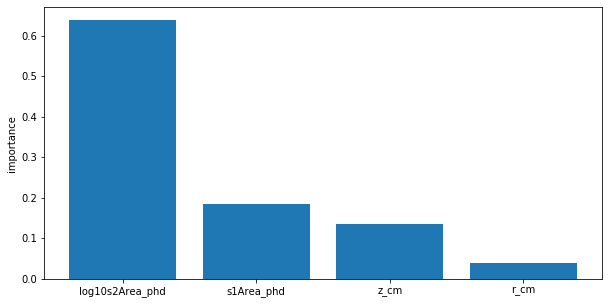

In [19]:
# Get feature ranking
importances = np.array(list(zip(variable_names, model.feature_importances_)))
# Sort in order of importance (then reverse so most important is first)
importances = importances[importances[:, 1].argsort()]
importances = importances[::-1]

# Plot variable importances
plt.figure(figsize=(10,5))
plt.bar(importances[:,0],importances[:,1].astype(float),bottom=0)
plt.ylabel("importance")
plt.show()

Unsurprisingly, S1 and S2 are the most important, though the remaining variables are also used. I find that such feature rankings for BDTs tend to put variables on more equal footing than you'd naively expect; they are most useful for culling uninteresting variables - i.e. you can try training using 20 variables, then rank them, and cut out the ones that are garbage. Note that BDTs are particularly robust to the addition of garbage variables, unlike generic neural nets.

Let's investigate some more. If we flatten the dataset to the S2 vs S1 plane, what does the BDT output look like? We can use this to gauge what's happening in a lower-dimensional space where we think we understand physically what should happen, and start diagnosing cases where we think the BDT made the wrong choice.

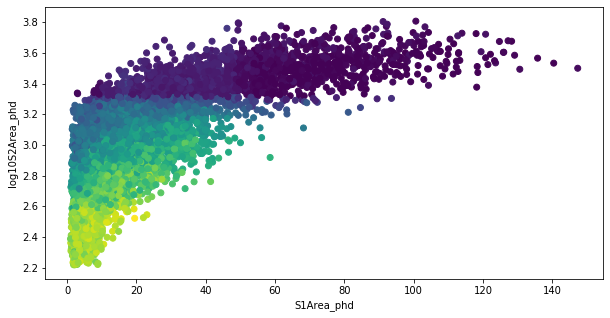

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(x_test_unscaled[:,0],x_test_unscaled[:,1],c=y_pred_test)
plt.ylabel('log10S2Area_phd')
plt.xlabel('S1Area_phd')
plt.show()

Lastly, we can take a look at what individual decision trees in the BDT are doing. sklearn in particular has a very nice feature for this visualization, though it uses the graphviz package which isn't installed here (see the code below to install). Here's the result for the very first tree, which is the one that (by definition) is the most important for the dataset as a whole:

<img src="https://raw.githubusercontent.com/swkravitz/dance-ml-2020-tutorial/master/images/ML_tutorial_tree.png">

Note: the Gini index is a measure of the purity of a sample. It equals 0 when samples are entirely from one class, and 0.5 when an even mixture. The exact definition is rooted in information theory, and it is one of the metrics that can be used to choose what cuts the decision tree makes during training.

Without graphviz, you can do a poor-man's version of the tree visualization above:

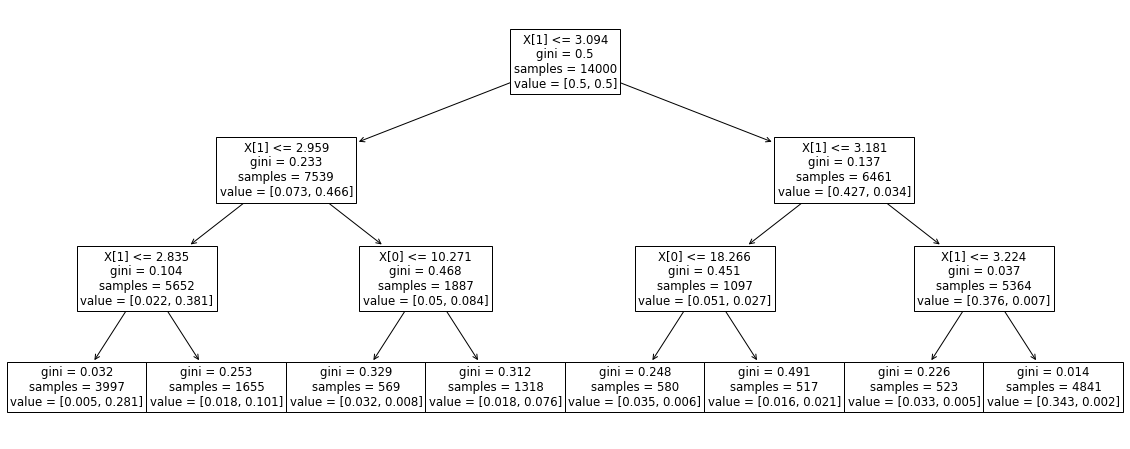

In [23]:
from sklearn import tree
DT_0 = model.estimators_[0]
plt.figure(figsize=(20,8))
tree.plot_tree(DT_0)
plt.show()

Below is some code you can to install graphviz to make the nicer plot above

In [18]:
# !pip install --user -q graphviz
# !conda install -c conda-forge graphviz --yes

In [19]:
# import os
# # Change path below to match your username/path:
# os.environ["PATH"] += os.pathsep + '/global/u2/w/watson_j/.conda/pkgs/graphviz-2.38.0-4/bin/'# not needed if already in PATH variable

# os.environ["PATH"] += os.pathsep + '/path/to/Anaconda3/Library/bin/graphviz/' # not needed if already in PATH variable

# dot_data = tree.export_graphviz(DT_0, out_file=None, 
#                       feature_names=variable_names,  
#                       class_names=["CH3T","DD"],  
#                       filled=True, rounded=True,  
#                       proportion=True,
#                       special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph.render(filename='filename_to_save',format='pdf')
# graph

We can call the code below to save the BDT object as a pickle file (a Python file type), to be read in later if desired:

In [24]:
# import pickle
# model_filename = 'BDT_model.pickle'
# pickle.dump(model, open(model_filename, 'wb'))

And we can call the code below to read that file back in, giving us the same `model` object that we had before:

In [21]:
# import pickle
# model_filename = 'BDT_model.pickle'
# with open(model_filename, 'rb') as f:
#     model = pickle.load(f, encoding="latin1")

## Adjusting your training set by re-weighting

The performance we see here is good, but are we really asking the right question when we set up this problem? This may be representative of how well we could separate CH3T and DD events, but they occupy somewhat different energy ranges. If what we really want to know is how to distinguish electron recoils from nuclear recoils in detector data, e.g. at the same observed S1 size, then we may be overestimating our real performance by using these calibration sources as our proxies. 

To make this closer to what we're really trying to ask, let's see what happens if we re-weight our training set so we get flat distributions in S1.

In [21]:
# Restrict the S1 range; we have to have at least some data from both classes for each energy bin for this to work
s1_min=5
s1_max=25

s1_cut_dd = (dd_df['s1Area_phd']>s1_min)&(dd_df['s1Area_phd']<s1_max)
dd_df = dd_df[s1_cut_dd]

s1_cut_ch3t = (ch3t_df['s1Area_phd']>s1_min)&(ch3t_df['s1Area_phd']<s1_max)
ch3t_df = ch3t_df[s1_cut_ch3t]

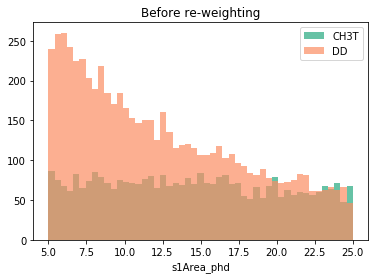

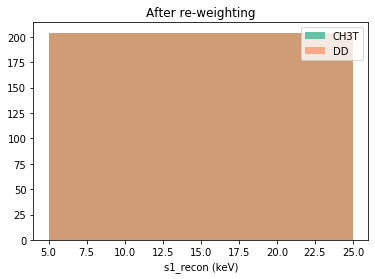

Total DD events after cuts:  6317
Total CH3T events after cuts:  3387
Total DD weight after cuts:  10000.0
Total CH3T weight after cuts:  10000.0


In [22]:
# Histogram the data into S1 bins, then re-weight data within each bin
s1_bins = np.linspace(s1_min, s1_max, 50)
(er_area, er_bins, _) = plt.hist(ch3t_df['s1Area_phd'],bins=s1_bins, label='CH3T', color=CH3T_color)
(nr_area, nr_bins, _) = plt.hist(dd_df['s1Area_phd'],bins=s1_bins,alpha=0.7, label='DD', color=DD_color)
plt.xlabel('s1Area_phd')
plt.legend()
plt.title('Before re-weighting')

s1_ind_er = np.digitize(ch3t_df['s1Area_phd'], bins=s1_bins)-1 # have to subtract 1 due to bin indexing
s1_ind_nr = np.digitize(dd_df['s1Area_phd'], bins=s1_bins)-1

# Get weights
weight_scale = n_evts_target/np.sum(1/nr_area[s1_ind_nr]) # scale weights to keep them of order 1
weight_er = weight_scale/er_area[s1_ind_er]
weight_nr = weight_scale/nr_area[s1_ind_nr]

plt.figure()
plt.hist(ch3t_df['s1Area_phd'],bins=s1_bins,weights=weight_er, label='CH3T', color=CH3T_color)
plt.hist(dd_df['s1Area_phd'],bins=s1_bins,weights=weight_nr, alpha=0.7, label='DD', color=DD_color)
plt.xlabel('s1_recon (keV)')
plt.legend()
plt.title('After re-weighting')
plt.show()

print("Total DD events after cuts: ",len(dd_df))
print("Total CH3T events after cuts: ",len(ch3t_df))

dd_df['weight'] = weight_nr
ch3t_df['weight'] = weight_er

print("Total DD weight after cuts: ",np.sum(dd_df['weight']))
print("Total CH3T weight after cuts: ",np.sum(ch3t_df['weight']))

Note that this weighting scheme also accounts for the fact that the number of events of each class surviving the energy cut is not the same.

**Now we do all the same steps, but with weights included:**

In [23]:
# Combine signal and background datasets
df = ch3t_df.append(dd_df)
df = df.sample(frac=1).reset_index(drop=True) # Shuffle

# Get some simple derived variables (more human-interpretable; not necessary for deep learning applications, may help simpler algorithms)
df['log10s2Area_phd'] = np.log10(df['s2Area_phd'])
df['r_cm'] = np.sqrt(df['x_cm']**2+df['y_cm']**2)

# Separate class info from inputs (no cheating!)
y_df = df.pop('class')

# Reduce to only the variables we want to train on, use numpy array format
X_unscaled = np.array(df[variable_names])
Y = np.array(y_df)
weights = np.array(df['weight'])

# Split data into training and testing (70/30 split); shuffle order, just in case the indexing of the input data carries information
# Stratify option ensures train and test split preserves percentage of samples in each class; most important when one or more classes have low stats
# Note that the 70/30 split is on number of events, not summed weight, so this won't be exact, but should be good enough 
x_train_unscaled, x_test_unscaled, y_train, y_test, w_train, w_test = train_test_split(X_unscaled, Y, weights, test_size=0.3, random_state=0, shuffle=True, stratify=Y)

# Perform initial transformations - StandardScaler sets mean of each feature to 0, std to 1
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled) # Use same scaling transformation on test and train data (do not pick a new mean, std)
X = scaler.transform(X_unscaled) 

Let's also visualize this weighted set, with marker size representing weight

**Note: the diagonal plots are before weighting (seaborn isn't set up for this)**

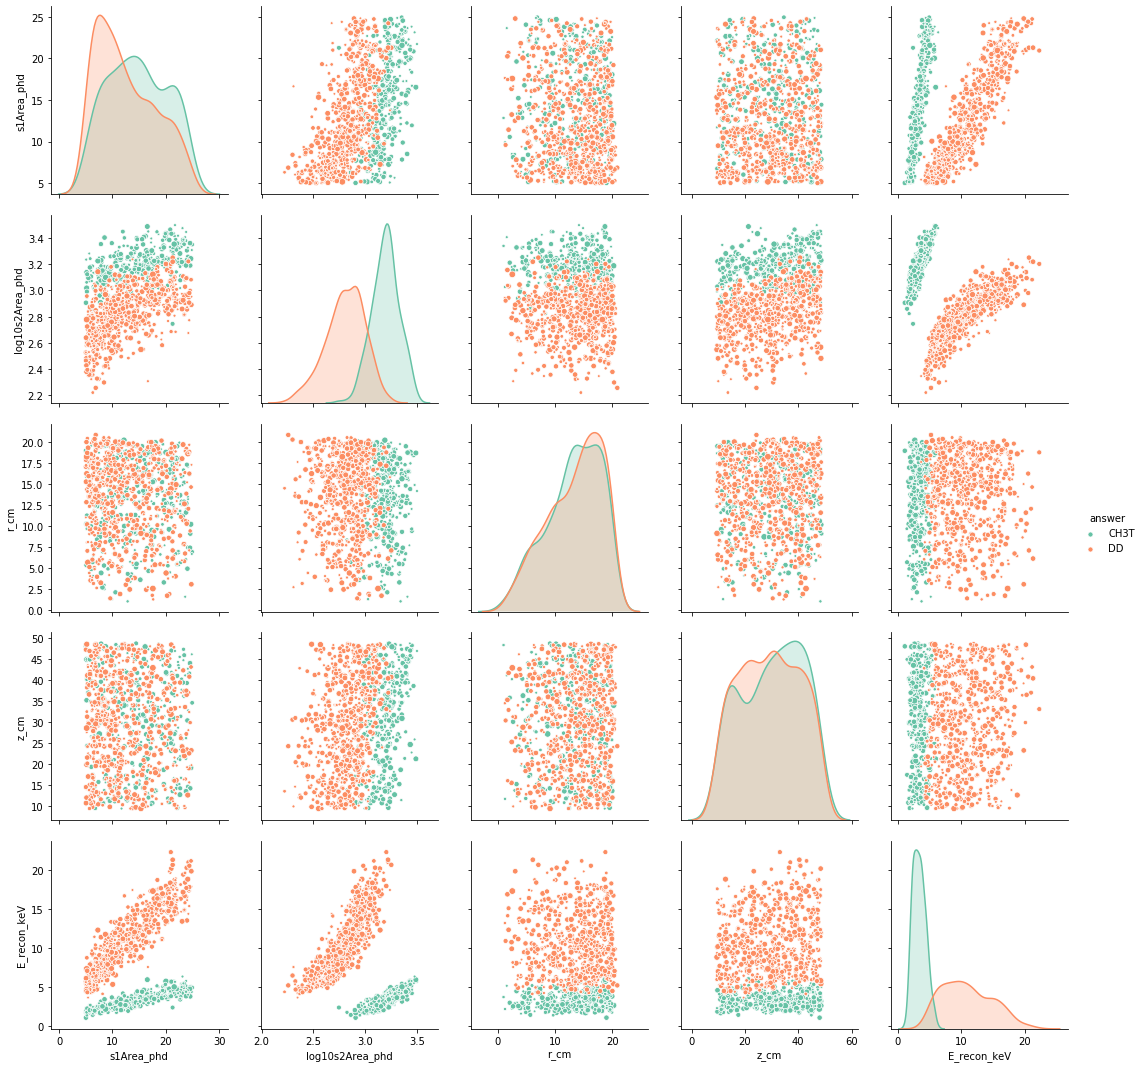

In [30]:
# Let's also visualize this weighted set
df['answer']='CH3T'
df.loc[y_df==1,'answer']='DD'
df['answer'] = df['answer'].astype('category')

display_vars = variable_names+['E_recon_keV']

g = sns.pairplot(df.head(1000), vars=display_vars, hue='answer', palette="Set2", height=3, plot_kws=dict(s=10.*df['weight'].head(1000))) 

In [31]:
# Make the base classifier (single decision tree) - not yet trained, includes termination condition
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=10)
# Now combine a bunch of decision trees; number set by n_estimators. 
# The specific way samples are re-weighted is controlled by the AdaBoost algorithm
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=100,algorithm = 'SAMME')

# Train the BDT! One line, very fast
model = BDT.fit(x_train_unscaled, y_train, sample_weight=w_train) # BDT looks at each feature independently, so scaling is typically not necessary

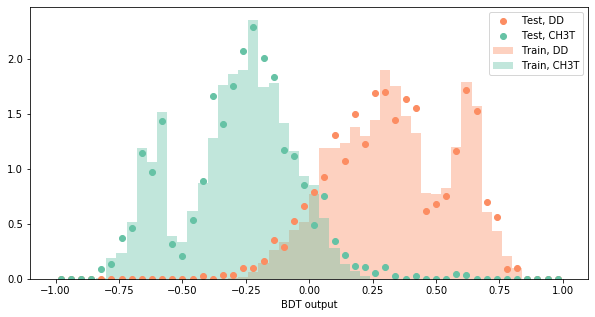

In [32]:
# Evaluate the BDT on the test (and train) data
y_pred_test = model.decision_function(x_test_unscaled)
y_pred_DD_train = model.decision_function(x_train_unscaled[y_train==1])
y_pred_DD_test = model.decision_function(x_test_unscaled[y_test==1])
y_pred_ch3t_train = model.decision_function(x_train_unscaled[y_train==0])
y_pred_ch3t_test = model.decision_function(x_test_unscaled[y_test==0])
w_DD_train = w_train[y_train==1]
w_DD_test = w_test[y_test==1]
w_ch3t_train = w_train[y_train==0]
w_ch3t_test = w_test[y_test==0]

n_bins=50
hist_range=(-1.0,1.0)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,weights=w_DD_train,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, DD")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,weights=w_DD_test,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, DD")

plt.hist(y_pred_ch3t_train,bins=n_bins,weights=w_ch3t_train,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, CH3T")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,weights=w_ch3t_test,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, CH3T")

plt.legend()
plt.xlabel('BDT output')
plt.show()

How does the ROC curve compare to the case before weighting?

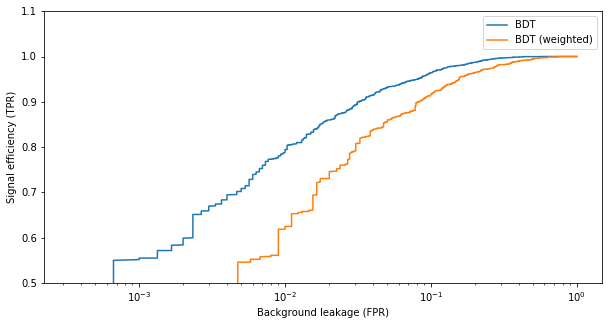

In [34]:
# Use the test data, since the training data can "cheat" by overfitting
# This time, pass the weights to the ROC calculator
BDT_weighted_FPR_test, BDT_weighted_TPR_test, BDT_weighted_TH_test = roc_curve(y_test, y_pred_test, sample_weight=w_test, pos_label=1) # Signal class set to 1

plt.figure(figsize=(10,5))
plt.plot(BDT_FPR_test, BDT_TPR_test, label="BDT")
plt.plot(BDT_weighted_FPR_test, BDT_weighted_TPR_test, label="BDT (weighted)")
plt.xscale('log')
plt.ylim((0.5,1.1))
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.legend()
plt.show()

We can see that distinguishing the two calibration sources for a **fixed S1 area** is a harder problem than when we use the natural S1 spectra of each source. 

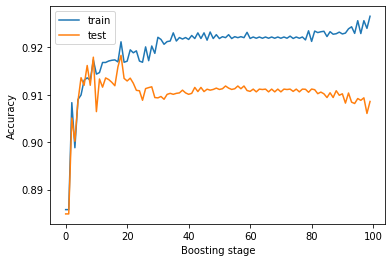

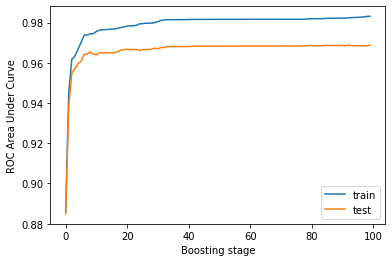

In [36]:
# Get accuracy, ROC AUC vs boosting stage, i.e. number of trees
# This time, pass the weights to the calculators
test_acc, train_acc = [], []
test_auc, train_auc = [], []
for train_predict in model.staged_predict(x_train_unscaled):
    train_acc.append(accuracy_score(y_train, train_predict, sample_weight=w_train)) # Can add sample weights here
    
for train_predict in model.staged_decision_function(x_train_unscaled):
    train_auc.append(roc_auc_score(y_train, train_predict, sample_weight=w_train))
    
for test_predict in model.staged_predict(x_test_unscaled):
    test_acc.append(accuracy_score(y_test, test_predict, sample_weight=w_test)) # Can add sample weights here
    
for test_predict in model.staged_decision_function(x_test_unscaled):
    test_auc.append(roc_auc_score(y_test, test_predict, sample_weight=w_test))
    
plt.plot(train_acc,label="train")
plt.plot(test_acc,label="test")
plt.xlabel("Boosting stage")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(train_auc,label="train")
plt.plot(test_auc,label="test")
plt.xlabel("Boosting stage")
plt.ylabel("ROC Area Under Curve")
plt.legend()
plt.show()

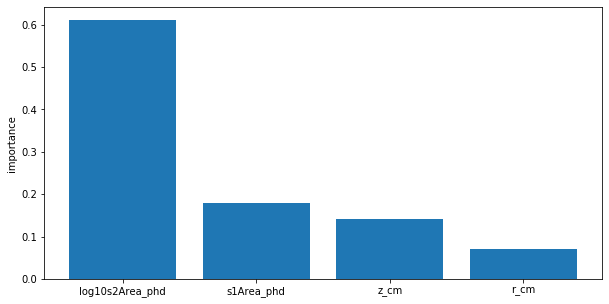

In [38]:
# Get feature ranking
importances = np.array(list(zip(variable_names, model.feature_importances_)))
# Sort in order of importance (then reverse so most important is first)
importances = importances[importances[:, 1].argsort()]
importances = importances[::-1]

# Plot variable importances
plt.figure(figsize=(10,5))
plt.bar(importances[:,0],importances[:,1].astype(float),bottom=0)
plt.ylabel("importance")
plt.show()

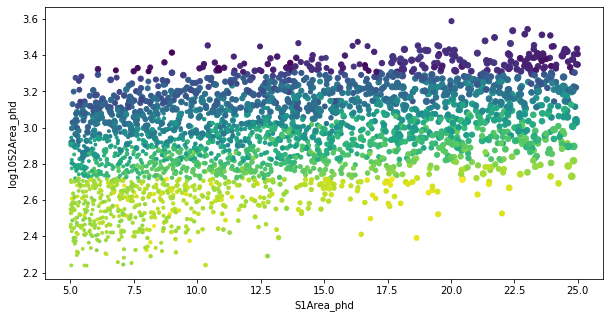

In [41]:
plt.figure(figsize=(10,5))
plt.scatter(x_test_unscaled[:,0],x_test_unscaled[:,1],c=y_pred_test, s=10.*w_test)
plt.ylabel('log10S2Area_phd')
plt.xlabel('S1Area_phd')
plt.show()

## Neural Nets with TensorFlow 2

Now let's consider the same workflow with neural nets using TensorFlow 2. A good, interactive theoretical introduction to them can be found here (link).

For now, let's leave it with this simple picture:

<img src="https://raw.githubusercontent.com/swkravitz/dance-ml-2020-tutorial/master/images/NN_example.png" width="600">

This shows that a neural net takes the inputs and forms a series of outputs (nodes, denoted by circles above) by taking a weighted sum that then goes through an activation function (_f_ above). This process is repeated for as many times as there are layers, at which point the final output (in our case a single value) is calculated. We can train the net to try to reproduce any goal value(s) by setting the output(s) in the training data to those. In our case, since the goal is to predict signal or background (binary classification), we can achieve this by setting the output to 0 for background and 1 for signal, as we have already done. However, you can see how this architecture readily allows for more complex cases, such as trying to match a continuous variable (this is called regression), or even many continuous variables.

In constructing a net, we have free rein to choose the shape of the network, i.e. number of hidden layers (depth) and number of nodes per layer (width). We can also choose which function to use for activation at various steps, as well as the algorithm used to optimize the weights during training.

Here we'll go through the creation of a simple fully-connected (dense) neural network in TensorFlow 2 using its Keras API 
(n.b. Keras used to be a standalone package that could run TensorFlow). We'll first make a helper function to allow easy adjustment of the network topology:

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import initializers as ki
from tensorflow.keras.metrics import AUC, Accuracy

#  Neural Network function which takes a topology vector (layer_vector)
#  Example of layer_vector; [1,4,1]  -  Network with one hidden layer of four nodes, one input and one output.
def neural_network( layer_vector ):
    model = Sequential() # The simplest networks like that shown above are all of the sequential type
    #  We add the first layer, and initialize the weights according to a Gaussian 
    model.add( Dense( layer_vector[1], input_dim=layer_vector[0], kernel_initializer=ki.RandomNormal(mean=0.0,stddev=1.0), use_bias=True ) )
    
    for i in range( 1, len( layer_vector ) - 1 ):
        #  This "layer" object applies the activation from the output of the previous
        model.add( Activation( 'tanh' ) )
        #  Adding the next layer
        model.add( Dense( layer_vector[i+1], kernel_initializer=ki.RandomNormal(mean=0.0,stddev=1.0), use_bias=True ) )
        
    model.add( Activation( 'sigmoid' ) )
    #  This compiles the network; the loss defines what we are trying to minimize by adjusting the network weights
    #  The optimizer decides the algorithm that does this minimization
    model.compile( loss= 'mean_squared_error', optimizer='Nadam', metrics=['accuracy',tf.keras.metrics.AUC(name='auc')]  )
    return model

In [42]:
# Simple neural network architecture
# Has our 4 input variables, a fully-connected hidden layer with 10 nodes, a second such layer with 3 nodes, and a final output node
# The specific architecture is typically not so important, but here are some general guidelines:
# At least one hidden layer should have more nodes than the inputs, so that the information can be expanded into higher dimensions
# Having a few hidden layers tends to speed up training, but also increases model complexity
# Depth (number of hidden layers) is usually more important than width (size of hidden layers)
model = neural_network([len(variable_names), 10, 3, 1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 87
Trainable params: 87
Non-trainable params: 0
____________________________________________________________

**Let's stick with the weighted version of the training data, for more generality**

In [50]:
# Fit model and gauge performance
# We're using the scaled data, as the neural net doesn't start out with any sense of the scales of the underlying variables
# Make sure to pass the weights as well; note that weights are passed differently for training data than for validation data 
history = model.fit(x_train, y_train, sample_weight=w_train, validation_data=(x_test, y_test, w_test), epochs=50, batch_size=10, verbose=1)

# Note: Giving train/test data explicitly means the test set can be examined later, as we will do here.
# If you don't need this, you can instead pass the whole dataset and have Keras do the splitting for you:
# history = model.fit(X, Y, validation_split=0.3, epochs=50, batch_size=10, verbose=1)

Train on 6792 samples, validate on 2912 samples
Epoch 1/50
6792/6792 [==============================] - 5s 726us/sample - loss: 0.1172 - accuracy: 0.9236 - auc: 0.9768 - val_loss: 0.1316 - val_accuracy: 0.9148 - val_auc: 0.9712
Epoch 2/50
6792/6792 [==============================] - 2s 349us/sample - loss: 0.1162 - accuracy: 0.9240 - auc: 0.9770 - val_loss: 0.1291 - val_accuracy: 0.9128 - val_auc: 0.9717
Epoch 3/50
6792/6792 [==============================] - 3s 384us/sample - loss: 0.1154 - accuracy: 0.9215 - auc: 0.9769 - val_loss: 0.1290 - val_accuracy: 0.9166 - val_auc: 0.9718
Epoch 4/50
6792/6792 [==============================] - 3s 374us/sample - loss: 0.1156 - accuracy: 0.9218 - auc: 0.9771 - val_loss: 0.1278 - val_accuracy: 0.9172 - val_auc: 0.9717
Epoch 5/50
6792/6792 [==============================] - 3s 383us/sample - loss: 0.1153 - accuracy: 0.9220 - auc: 0.9770 - val_loss: 0.1294 - val_accuracy: 0.9124 - val_auc: 0.9713
Epoch 6/50
6792/6792 [==============================

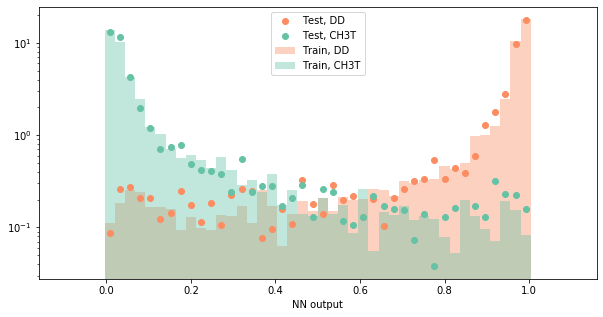

In [51]:
# What do the decision function outputs look like for signal vs background?
y_pred_test = model.predict(x_test).ravel() # reduce output to shape (n) instead of (n, 1)
y_pred_train = model.predict(x_train).ravel()
y_pred_DD_train = model.predict(x_train[y_train==1]).ravel()
y_pred_DD_test = model.predict(x_test[y_test==1]).ravel()
y_pred_ch3t_train = model.predict(x_train[y_train==0]).ravel()
y_pred_ch3t_test = model.predict(x_test[y_test==0]).ravel()
w_DD_train = w_train[y_train==1]
w_DD_test = w_test[y_test==1]
w_ch3t_train = w_train[y_train==0]
w_ch3t_test = w_test[y_test==0]

n_bins=50
hist_range=(-0.1,1.1)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,weights=w_DD_train,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, DD")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,weights=w_DD_test,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, DD")

plt.hist(y_pred_ch3t_train,bins=n_bins,weights=w_ch3t_train,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, CH3T")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,weights=w_ch3t_test,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, CH3T")

plt.legend()
plt.xlabel('NN output')
plt.yscale('log')
plt.show()

Note that the output is very strongly biased toward the ends of the range (log y-scale), even though the distributions still overlap. This is a common property of neural nets with a mean-square error optimization, as this optimization explicitly tries to match the output values of 0 or 1. This tends to exaggerate with more training epochs.

Now let's check for overtraining:

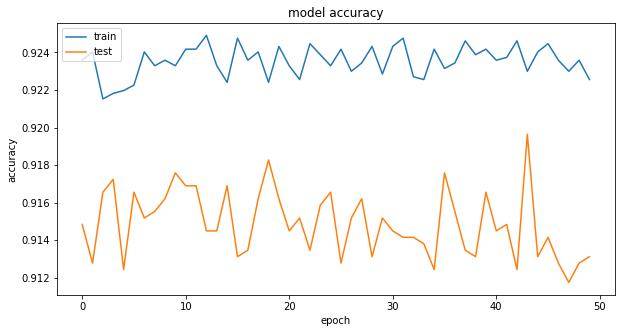

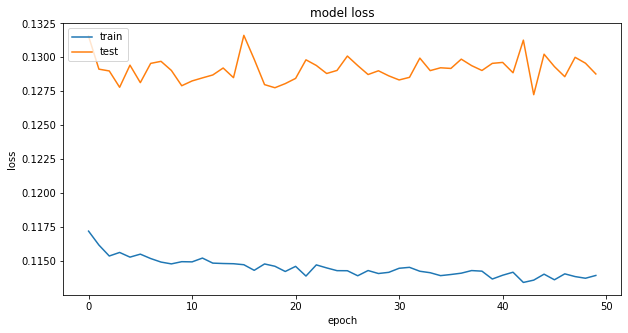

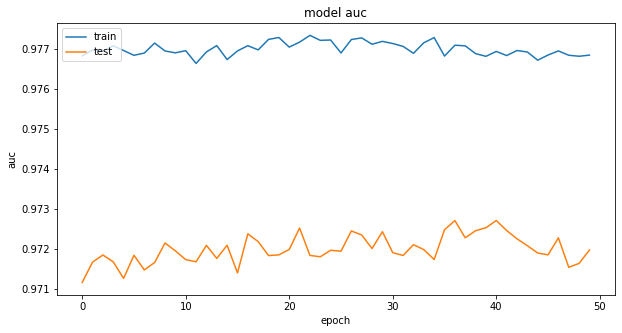

In [52]:
plt.figure(1,figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(2,figsize=(10,5))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(3,figsize=(10,5))
# summarize history for loss
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Again, these curves give an indication of if we are overtrained or not. If test performance seems to be still increasing (perhaps slowly), we can probably afford to train longer.

Now let's visualise the output in the S2 vs S1 plane again:

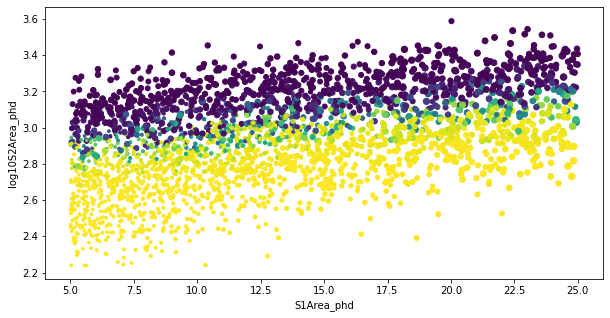

In [58]:
plt.figure(figsize=(10,5))
plt.scatter(x_test_unscaled[:,0],x_test_unscaled[:,1],c=y_pred_test,s=10.*w_test) # we want to use unscaled variables, since their scales have physical meaning here
plt.ylabel('log10S2Area_phd')
plt.xlabel('S1Area_phd')
plt.show()

We can call the code below to save the model in the TensorFlow [SavedModel](https://www.tensorflow.org/guide/saved_model) format, to be read in later if desired:

In [26]:
# This will create a directory called 'tf_NN_model' with all the relevant files needed to reconstruct the model
# model.save('tf_NN_model', save_format='tf') # can also save in the older Keras HDF5 format with save_format='h5'

More details on save formats [here](https://www.tensorflow.org/guide/keras/save_and_serialize).

And we can call the code below to read that file back in, giving us the same `model` object that we had before:

In [27]:
#from tensorflow.keras.models import load_model

# saved model includes architecture, weights, and optimizer history, among other things
#model = load_model('tf_NN_model')

**<p style="color:red;">Note: We used as inputs the *scaled* variables (unlike in the BDT case), which means that to get the same outputs later, we'll have to apply the same scaling factors to the data as we did here. </p>**

Let's see how the NN performs, and how it compares to the BDT:

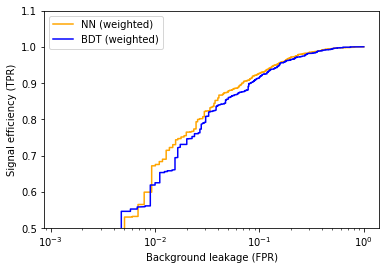

In [62]:
NN_FPR_test, NN_TPR_test, NN_TH_test = roc_curve(y_test, y_pred_test, sample_weight=w_test, pos_label=1) # Signal class set to 1

plt.plot(NN_FPR_test, NN_TPR_test, label="NN (weighted)", color='orange')
plt.plot(BDT_weighted_FPR_test, BDT_weighted_TPR_test, label="BDT (weighted)", color='blue')
plt.xscale('log')
plt.ylim((0.5,1.1))
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.legend()
plt.show()

We can see that they both do fairly similarly - this suggests (but doesn't prove) that they may be performing near the limit of what is possible given the information available in the dataset.

**Important note!** Comparing the performance of two algorithms on the same test set is not a statistically-rigorous way to gauge how they'll do on new data. You could try 10 algorithms and find by chance that one does significantly better on this specific test set, but not in general. What we really want to know is the *generalization error* which is how we might expect to do in the absence of statistical fluctuations. In general, the more data you have, the more robust you are to overtraining and the less important the statistical fluctuations. But to do a proper comparison, you can do something called _k-fold cross-validation_ (there are also other methods, read more [here](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)).

This consists of breaking your full dataset up into *k* partitions and using *k*-1 partitions (*folds*) to train, then the remaining partition to test performance (the *holdout data*), and repeating *k* times, with a different set of _holdout data_ each time. You then take the average (and variance) of whatever metric(s) of performance you care about to gauge how the algorithm generalizes. The value for *k* needed for good generalization will depend on your problem, but a reasonable approach is to start with *k*=10 for one algorithm, then try reducing/increasing *k* to find where the estimated metric starts to stabilize as a function of *k*. 

The problem of course is that this can become intractable if training isn't relatively fast, but you do model selection without some similar technique at your own peril. You can use this method to compare different algorithms, or the same algorithm with different hyperparameters (options chosen before training, such as max_depth for BDT or number/size of hidden layers or activation functions for NN).

## Cross-validation

In [24]:
# sklearn has some useful functions to help with this
# You do NOT have to use models from sklearn to take advantage of this
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.base import clone

# Helper function to do k-fold cross-validation 
# Note that sklearn does have a cross_val_score method, but you can't readily modify it to work with algorithms outside of sklearn
# and it also doesn't propagate weights correctly, so this is more general and works for weighted datasets
# X_, Y_, and W_ are the full (train+test) list of features, labels, and weights, respectively.
# model_ is the classifier to be trained
# cv is the cross validation object to use
# metrics is a list of metrics to evaluate on
# Returns a list of trained models (for each fold), a list of scores (for each metric and fold), and a list of indices used for the test partition (for each fold)
def k_fold_score_sklearn(X_, Y_, model_, cv, W_=None, metrics=[accuracy_score], verbose=False):
    if W_ is None: W_ = np.ones(np.shape(Y_))
    trained_models = []
    scores = [[] for metric in metrics]
    train_partitions = []
    test_partitions = []
    # Split up data into different random partitions and train/test on each split
    k_ind = 0
    for train, test in cv.split(X_, Y_):
        train_partitions.append(train)
        test_partitions.append(test)
        # Clone model to store trained version later
        model_clone = clone(model_)
        # Train model and make predictions on test data
        Y_pred_i = model_clone.fit(X_[train], Y_[train],sample_weight=W_[train]).predict(X_[test])
        # Score on test data, then store results
        Y_test_i = (Y_[test]==1) # Make labels binary as desired by some score functions
        Y_pred_i = (Y_pred_i==1)
        if hasattr(model_clone, 'decision_function'):
            Y_score_i = model_clone.decision_function(X_[test])
        for i, metric in enumerate(metrics):
            if metric == roc_auc_score:
                score = metric(Y_test_i, Y_score_i, sample_weight = W_[test])
            else:
                score = metric(Y_test_i, Y_pred_i, sample_weight = W_[test])
            scores[i].append(score)
        trained_models.append(model_clone)
        k_ind += 1
        if verbose: print("Model {0} of {1} trained".format(k_ind,cv.n_splits))
    scores = np.array(scores)
    return trained_models, scores, test_partitions

In [25]:
# Let's try 10-fold cross-validation
cv = StratifiedKFold(n_splits=10,shuffle=True)
DTC = DecisionTreeClassifier(max_depth=3,min_samples_split=10)
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=50,algorithm = 'SAMME')
_,scores,_ = k_fold_score_sklearn(X_unscaled, Y, BDT, cv, metrics=[accuracy_score,roc_auc_score], verbose=True)
print("Accuracy: %0.3f (+/- %0.4f)" % (scores[0].mean(), scores[0].std() * 2)) # 2 sigma range
print("ROC area: %0.3f (+/- %0.4f)" % (scores[1].mean(), scores[1].std() * 2)) # 2 sigma range

Model 1 of 10 trained
Model 2 of 10 trained
Model 3 of 10 trained
Model 4 of 10 trained
Model 5 of 10 trained
Model 6 of 10 trained
Model 7 of 10 trained
Model 8 of 10 trained
Model 9 of 10 trained
Model 10 of 10 trained
Accuracy: 0.979 (+/- 0.0112)
ROC area: 0.996 (+/- 0.0041)


Now we have a proper estimate of accuracy and ROC AUC for the case above, so we can compare it to a version with different hyperparameters, e.g. smaller max_depth (for less overtraining):

In [26]:
DTC = DecisionTreeClassifier(max_depth=2,min_samples_split=10)
BDT = AdaBoostClassifier(base_estimator=DTC,n_estimators=50,algorithm = 'SAMME')
_,scores,_ = k_fold_score_sklearn(X_unscaled, Y, BDT, cv, metrics=[accuracy_score,roc_auc_score], verbose=False)
print("Accuracy: %0.3f (+/- %0.4f)" % (scores[0].mean(), scores[0].std() * 2)) # 2 sigma range
print("ROC area: %0.3f (+/- %0.4f)" % (scores[1].mean(), scores[1].std() * 2)) # 2 sigma range

Accuracy: 0.977 (+/- 0.0196)
ROC area: 0.995 (+/- 0.0044)


We can see that they're both more or less the same (within error), probably with performance limited by the information available in the dataset itself. It is not uncommon for changes to the hyperparameters to have a small effect on the performance of a BDT - they are quite robust out-of-the-box.

We can apply a similar approach to an entire range of hyperparameters in multiple dimensions (this is called a grid search) to try to optimize, though it's really overkill for our case here.

You can modify the helper function above with some work to get something similar working for the TensorFlow neural network, so you can compare performance even across different packages.

## BDTs with XGBoost

### This section is identical to the sklearn/adaboost section, but uses XGBoost's interface, which is slightly more generalized. For more details on XGBoost, check out their paper: https://arxiv.org/abs/1603.02754. XGBoost doesn't change the fundamentals of the BDT algorithm too much. Mainly:

* XGBoost is a *regression* tree, not a classification tree, but classification is just a special case of regression.
* It also has an *approximate* algorithm which is a lot faster for large datasets (it is able to pick which algorithm is best, so you don't need to tweak it).
* It can use GPUs. 
* It will also handle *sparse inputs* aka if you have a missing column for some events it will handle it. Can be useful if you are training on events with differing topologies.
* Can learn in parallel.

In [ ]:
# If XGBoost isn't already installed:
# !pip install --user -q xgboost

In [28]:
import xgboost
# train, test = train_test_split(rdf, test_size=0.25, random_state=123)
# dtrain = xgb.DMatrix(train[['rsq', 'dt_us', 'phi'  ]], label = train['class'])
# dtest = xgb.DMatrix(test[['rsq', 'dt_us', 'phi' ]], label = test['class'])
#x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X_unscaled, Y, test_size=0.3, random_state=0, shuffle=True)

dtrain = xgboost.DMatrix(x_train_unscaled, label = y_train)
dtest = xgboost.DMatrix(x_test_unscaled, label = y_test)
#In XGBoost (and the previous BDT implementations) you can set the hyperparameters.
param = {'max_depth':6, # The trees will grow to this depth, so maximum 2^6 leaves
         'eta':.3, #shrink the weight of each stage by this amount (geometric series)
         'objective':'binary:logistic', # Probably don't mess with this
         'subsample':.9, #"Bagging" by randomly sampling rows with replacement this fraction of events in each stage. 
         'colsample_bylevel':1, #if you want to use "Random Forests" which resample on the columns, change to a number in [0,1]. 
                                 #Change "bylevel" to "bytree" or "bynode" to change when this resampling occurs (stage, depth, or node)
         'min_split_loss':1, #This is "Gamma" in the XGBoost paper, a proposed split needs to improve the loss function by this amount 
         'lambda':1, #L2 regularization. Can think of this as preventing the BDT from separating leaf too aggressively. 
                     #Probably don't need to tweak too much, the topological regularizers tend to have bigger effects. 
         #'monotone_constraints': '(-1,0,0)' # this one is really cool. If you know that you want the classifier
                                             #to generally increase (decrease) in a given direction, you can specify it,
                                             #and then the output will be monotonically increasing (decreasing)
        }

num_round = 100 #maximum number of rounds
progress = dict()
watchlist =  [ (dtrain, 'train'),(dtest, 'validation')] #as it is training, the BDT will evaluate on these datasets
bst = xgboost.train(param, dtrain, num_round,
                    evals = watchlist,
                    verbose_eval = 5 ,
                   # early_stopping_rounds = 50, #You can set this to stop training when the validation set starts to turn over (overtraining is occurring)
                    evals_result=progress)
for x in ['gain', 'weight', 'cover', 'total_gain', 'total_cover']:
    print('feature %s : %s'%(x,bst.get_score(importance_type = x)))
    
#save the model! This will allow us to read it back in later
bst.save_model('fb_bdt.xgb')

# We can later load the model back in with code like this:
#bst = xgb.Booster({'nthread': 4})  # init model
#bst.load_model('model.bin')  # load data

[0]	train-error:0.019048	validation-error:0.028333
[5]	train-error:0.014048	validation-error:0.022222
[10]	train-error:0.011429	validation-error:0.020556
[15]	train-error:0.01	validation-error:0.018889
[20]	train-error:0.009048	validation-error:0.018333
[25]	train-error:0.006667	validation-error:0.018889
[30]	train-error:0.00619	validation-error:0.020556
[35]	train-error:0.004762	validation-error:0.020556
[40]	train-error:0.00381	validation-error:0.020556
[45]	train-error:0.003333	validation-error:0.022222
[50]	train-error:0.002619	validation-error:0.022778
[55]	train-error:0.002381	validation-error:0.022778
[60]	train-error:0.002381	validation-error:0.022222
[65]	train-error:0.002381	validation-error:0.021667
[70]	train-error:0.002381	validation-error:0.022778
[75]	train-error:0.002381	validation-error:0.022778
[80]	train-error:0.002381	validation-error:0.022778
[85]	train-error:0.002143	validation-error:0.021111
[90]	train-error:0.002143	validation-error:0.021111
[95]	train-error:0.0

Let's see how the error changes versus boosting stage to judge overtraining:

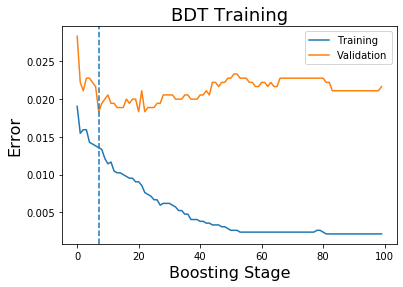

In [29]:
plt.plot(progress['train']['error'], label='Training')
plt.plot(progress['validation']['error'], label ='Validation')
plt.axvline(np.argmin(progress['validation']['error']), ls = '--')
plt.xlabel('Boosting Stage', fontsize = 16)
plt.ylabel('Error', fontsize = 16)
plt.title('BDT Training', fontsize = 18)
plt.legend()

Now lets plot the outputs. Note that, because XGBoost is a *regressor*, the output is from 0 to 1, since those were the labels. We could have done this same process on a continuous label, but it's not as common to use it this way.

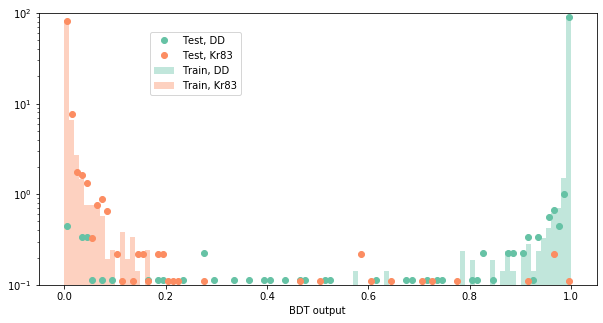

In [30]:
# What do the decision function outputs look like for signal vs background?
y_pred_test = bst.predict(dtest)
y_pred_train = bst.predict(dtrain)
y_pred_DD_train = y_pred_train[y_train==1]
y_pred_DD_test = y_pred_test[y_test==1]
y_pred_ch3t_train = y_pred_train[y_train==0]
y_pred_ch3t_test = y_pred_test[y_test==0]

n_bins=100
hist_range=(0,1)
DD_color = sns.color_palette("Set2")[1]
CH3T_color = sns.color_palette("Set2")[0]
plt.figure(figsize=(10,5))
plt.hist(y_pred_DD_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=DD_color,label="Train, DD")
counts,bin_edges = np.histogram(y_pred_DD_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers, counts,marker="o",linestyle="None",color=DD_color,label="Test, DD")

plt.hist(y_pred_ch3t_train,bins=n_bins,range=hist_range,density=True,alpha=0.4,color=CH3T_color,label="Train, ch3t")
counts,bin_edges = np.histogram(y_pred_ch3t_test,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.semilogy(bin_centers, counts,marker="o",linestyle="None",color=CH3T_color,label="Test, ch3t")

plt.legend(loc = (.2, .7))
plt.xlabel('BDT output')
plt.ylim(0.1, 100)
plt.show()

This highlights an important difference between the sklearn BDT algorithm and the XGBoost algorithm: in the XGBoost case, the algorithm is doing regression with individual trees rather than binary classification (as in the sklearn case). This means the output ends up looking closer to that of a neural net, i.e. skewed toward the extremes.

In [31]:
alpha = 1- np.sum(y_pred_DD_test)/len(y_pred_DD_test)
beta =  np.sum(y_pred_ch3t_test)/len(y_pred_ch3t_test)
print('Misclassification: %.3f %.3f'%(alpha, beta))

Misclassification: 0.032 0.020


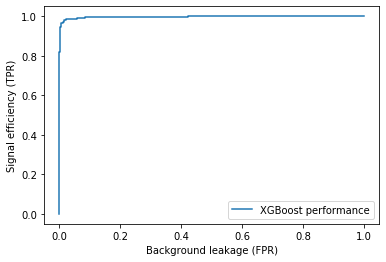

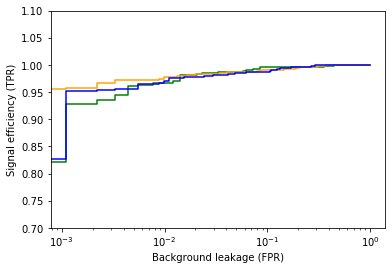

In [32]:
XGB_FPR_test, XGB_TPR_test, XGB_TH_test = roc_curve(y_test, y_pred_test, pos_label=1) # Signal class set to 1
plt.plot(XGB_FPR_test, XGB_TPR_test, label="XGBoost performance")
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')

#n_pts = 100
#bkg_eff = np.linspace(0,1,n_pts)
#sig_fixed = np.sqrt(bkg_eff)
#plt.plot(bkg_eff, sig_fixed, label="Const sig/sqrt(bkg)", color='black')
plt.legend()
plt.show()

plt.plot(XGB_FPR_test, XGB_TPR_test, label="XGBoost performance", color='green')
plt.plot(NN_FPR_test, NN_TPR_test, label="NN performance", color='orange')
plt.plot(BDT_FPR_test, BDT_TPR_test, label="sklearn BDT performance", color='blue')
plt.xscale('log')
plt.ylim((0.7,1.1))
plt.xlabel('Background leakage (FPR)')
plt.ylabel('Signal efficiency (TPR)')
plt.show()

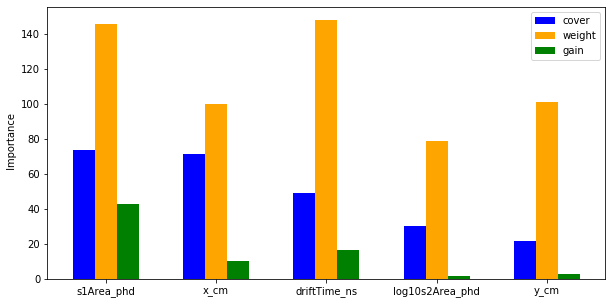

In [34]:
# Get feature ranking
index = np.arange(5)
bar_width = .2
# Sort in order of importance (then reverse so most important is first)
sorted_order = None

# Plot variable importances
plt.figure(figsize=(10,5))
plt.ylabel(" Importance")
colors = ['b', 'orange', 'g']
for k, importance in enumerate(['cover', 'weight', 'gain']):
    importances =  np.array(list(bst.get_score(importance_type = importance).values()))
#     importances
#     importances = importances / np.max(importances)
    if sorted_order is None:
        sorted_order = importances.argsort()[::-1]
    importances = importances[sorted_order]
    plt.bar(index + k*bar_width,importances.astype(float), bar_width,bottom=0, label = importance, color = colors[k] )
#     plt.gca().twinx()
plt.xticks(index + bar_width, np.array(variable_names)[sorted_order])
plt.legend(loc = 'best')
plt.show()

In [51]:
# If you've set up graphviz using the instructions from the sklearn BDT section, you can visualize the trees from XGBoost:
#stage = 2
#xgboost.to_graphviz(bst,num_trees=stage, condition_node_params = {'shape': 'box',
# 'style': 'filled,rounded','fillcolor': '#78bceb','fontsize': '10'},
#  leaf_node_params = {'shape': 'box','style': 'filled','fillcolor': '#e48038', 'fontsize':'10'})

## Exercises

Now try making some changes and seeing what happens!
Some things to consider:

Try adding new input variables (reload the dataset with branch_names updated, then change the variable_names as well) - this may boost performance, but the added complexity also means a higher risk of overtraining

Try adjusting the number of trees (BDT) or the number of epochs trained for (NN) to avoid overtraining

Try adjusting the hyperparameters (e.g. max_depth for BDT, number/size of hidden layers or activation functions for NN, ...)

Take a look at the events that are misclassified - can you figure out what's going wrong and how to address it? 